A simple script to read in CTD data collected with the mini CTD used in the KSA205 field trip and made some simple profil's; plots and little contour plots for the transect. Make sure this script and your CTD data file are in the same directory.

In [115]:
import cmocean as cm
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.simplefilter("ignore", category=UserWarning)

## Open data

This time we want to load multiple `.csv` files that are stored in three different directories. We will define a function that iterates through all of them, extracting the information we need to plot: latitude and longitude positions, pressures, depths, salinity, temperatures and density.

The function will take as input the file "paths" (an address within the file sustem ;) ), open the file and extract information like we have done in `plot_CTD_profiles.ipynb`:

In [48]:
def extract_data(path_to_profile):

    lon = np.float32(pd.read_csv(path_to_profile).iloc[9,1])
    lat = np.float32(pd.read_csv(path_to_profile).iloc[8,1])

    data = pd.read_csv(path_to_profile, skiprows = 28)
    pressure = data.iloc[:,0]
    depth = data.iloc[:,1] 
    temperature = data.iloc[:,2]
    salinity = data.iloc[:,5] 
    density = data.iloc[:,7]
    lat_array = np.ones(len(depth))*lat
    lon_array = np.ones(len(depth))*lon

    CTD_data_station = {}
    CTD_data_station['longitude'] = lon_array
    CTD_data_station['latitude'] = lat_array
    CTD_data_station['pressure'] = pressure
    CTD_data_station['depth'] = depth
    CTD_data_station['salinity'] = salinity
    CTD_data_station['temperature'] = temperature
    CTD_data_station['density'] = density

    return CTD_data_station

Now we can use the function to iterate through our files and open the data we need. To get the file paths we can use the library `glob`:

In [49]:
first_trip = np.sort(glob.glob('first_trip/*.csv'))
second_trip = np.sort(glob.glob('second_trip/*.csv'))
third_trip = np.sort(glob.glob('third_trip/*.csv'))

In [50]:
first_trip

array(['first_trip\\CC2225003_20240411_000406.csv',
       'first_trip\\CC2225003_20240411_002032.csv',
       'first_trip\\CC2225003_20240411_003354.csv',
       'first_trip\\CC2225003_20240411_005028.csv'], dtype='<U40')

In [51]:
CTDData = {}
n = 0
for path in first_trip:
    CTDData[n] = extract_data(path)
    n += 1
for path in second_trip:
    CTDData[n] = extract_data(path)
    n += 1
for path in third_trip:
    CTDData[n] = extract_data(path)
    n += 1

We have created a "dictionary" of CTD stations. The first station of the first trip is station number 0, and within it we have different variables:

In [52]:
CTDData[0].keys()

dict_keys(['longitude', 'latitude', 'pressure', 'depth', 'salinity', 'temperature', 'density'])

You can call them by their name:

In [53]:
CTDData[0]['depth']

0      0.149605
1      0.448808
2      0.747928
3      1.046947
4      1.345911
        ...    
59    17.764560
60    18.062953
61    18.361347
62    18.659739
63    18.903735
Name: Depth (Meter), Length: 64, dtype: float64

# Plot the locations

Let's plot the locations of each CTD station, with a different color for each trip.

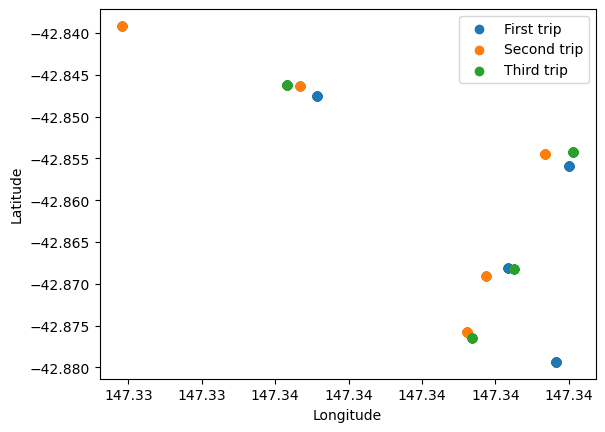

In [116]:
colors = ['C0','C0','C0','C0',
          'C1','C1','C1','C1','C1',
          'C2','C2','C2','C2',]
n = 0
for i in list(CTDData.keys()):
    if n == 0:
        legend = 'First trip'
    elif n == 4:
        legend = 'Second trip'
    elif n == 9:
        legend = 'Third trip'
    else:   
        legend = None
    plt.scatter(CTDData[i]['longitude'], CTDData[i]['latitude'], c = colors[n], label = legend) 
    n+=1
plt.legend();
plt.ylabel('Latitude');
plt.xlabel('Longitude');
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'));

## Plot a cross section

Let's select all the stations from the first trip and create a contour plot. For that, we will loop again through our dictionary of data and extract the variable of interest (we will start with temperature) and save it to a matrix:

In [117]:
# Get the station with the largest number of depth levels to set the matrix dimension
N = len(first_trip)
N_depth_levels = 0
for n in range(N):
    depth_levels = len(CTDData[n]['depth'])
    if depth_levels > N_depth_levels:
        N_depth_levels = depth_levels

# Create the empty matrix with nans
depths = np.empty([N, N_depth_levels]) * np.nan
salinity = np.empty([N, N_depth_levels]) * np.nan
lat = np.ones([N, N_depth_levels]) 
lon = np.ones([N, N_depth_levels]) 

# Iterate and fill the matrices
for n in range(N):
    depth_levels = len(CTDData[n]['depth'])
    depths[n, :depth_levels] = CTDData[n]['depth']
    salinity[n, :depth_levels] = CTDData[n]['salinity']
    lon[n, :] = CTDData[n]['longitude'][0]*lon[n,:]
    lat[n, :] = CTDData[n]['latitude'][1]*lat[n,:]

In [111]:
labels = [str(np.round(lat[i,0], 2)) +'S \n '+str(np.round(lon[i,0], 2))+'E' for i in range(len(lat[:,0]))] 

C:\Users\jmneme\AppData\Local\Temp\ipykernel_18692\2376054629.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(PC)


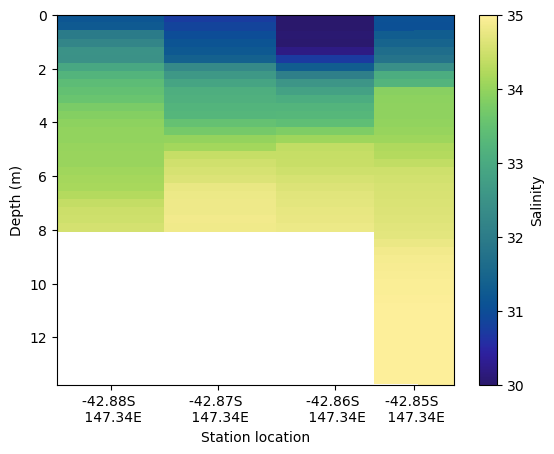

In [120]:
PC = plt.pcolor(lat, depths, salinity, vmin = 30, vmax = 35, cmap = cm.cm.haline);
cbar = plt.colorbar(PC)
cbar.set_label('Salinity');
plt.xticks(lat[:, 0], labels);
plt.gca().invert_yaxis();
plt.ylabel('Depth (m)');
plt.xlabel('Station location');

We can change the x-axis to be distance from the first station. For that we will use the functions `lat2m` and `lon2m` from Week 3, and then calculate the distance $D$ as:

$$
D = \sqrt{(D_{lat})^2 + (D_{lon})^2}
$$

In [121]:
def lat2m(numdegrees):
    '''
    Takes distance in degrees of latitude and converts to approx 
    meters, assumes spherical Earth
    '''
    earth_radius = 6378137 #meters
    earth_circ = 2*np.pi*earth_radius
    degrees = earth_circ/360

    output = numdegrees*degrees        

    return output

def lon2m(numdegrees, latitude):
    '''
    Takes distance in degrees of longitude and converts to approx 
    meters, assumes spherical Earth
    '''
    earth_radius = 6378137 #meters
    earth_circ = 2*np.pi*earth_radius
    degrees = earth_circ/360

    output = numdegrees*degrees*np.cos(np.pi*latitude/180)
    
    return output

In [122]:
D = np.zeros_like(depths);
for i in range(1, len(salinity[:,0])):
    D_lat = lat2m(lat[i, 0] - lat[i-1, 0])
    D_lon = lon2m(lon[i, 0] - lon[i-1, 0], np.mean([lat[i,0], lat[i-1,0]]))
    D[i, :] = np.sqrt(D_lat**2 + D_lon**2)+D[i-1,0]

C:\Users\jmneme\AppData\Local\Temp\ipykernel_18692\1000478357.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(PC)


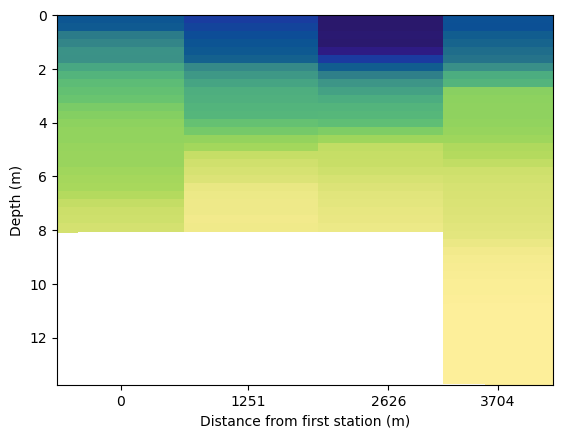

In [124]:
plt.pcolor(D, depths, salinity, vmin = 30, vmax = 35, cmap = cm.cm.haline);
cbar = plt.colorbar(PC)
cbar.set_label('Salinity');
plt.xticks(D[:, 0]);
plt.gca().invert_yaxis();
plt.ylabel('Depth (m)');
plt.xlabel('Distance from first station (m)');

Let's do all three trips in separate panels:

In [125]:
# Get the station with the largest number of depth levels to set the matrix dimension
N2 = len(second_trip)
N_depth_levels = 0
for n in range(N2):
    depth_levels = len(CTDData[n]['depth'])
    if depth_levels > N_depth_levels:
        N_depth_levels = depth_levels

# Create the empty matrix with nans
depths2 = np.empty([N2, N_depth_levels]) * np.nan
salinity2 = np.empty([N2, N_depth_levels]) * np.nan
lat2 = np.empty([N2, N_depth_levels]) * np.nan
lon2 = np.empty([N2, N_depth_levels]) * np.nan

# Iterate and fill the matrices
for n in range(N2):
    depth_levels = len(CTDData[n]['depth'])
    depths2[n, :depth_levels] = CTDData[n]['depth']
    salinity2[n, :depth_levels] = CTDData[n]['salinity']
    lon2[n, :depth_levels] = CTDData[n]['longitude']
    lat2[n, :depth_levels] = CTDData[n]['latitude']

# Get distance
D2 = np.zeros_like(depths2);
for i in range(1, len(salinity2[:,0])):
    D_lat = lat2m(lat2[i, 0] - lat2[i-1, 0])
    D_lon = lon2m(lon2[i, 0] - lon2[i-1, 0], np.mean([lat2[i,0], lat2[i-1,0]]))
    D2[i, :] = np.sqrt(D_lat**2 + D_lon**2)+D2[i-1,0]

In [126]:
# Get the station with the largest number of depth levels to set the matrix dimension
N3 = len(third_trip)
N_depth_levels = 0
for n in range(N3):
    depth_levels = len(CTDData[n]['depth'])
    if depth_levels > N_depth_levels:
        N_depth_levels = depth_levels

# Create the empty matrix with nans
depths3 = np.empty([N3, N_depth_levels]) * np.nan
salinity3 = np.empty([N3, N_depth_levels]) * np.nan
lat3 = np.empty([N3, N_depth_levels]) * np.nan
lon3 = np.empty([N3, N_depth_levels]) * np.nan

# Iterate and fill the matrices
for n in range(N3):
    depth_levels = len(CTDData[n]['depth'])
    depths3[n, :depth_levels] = CTDData[n]['depth']
    salinity3[n, :depth_levels] = CTDData[n]['salinity']
    lon3[n, :depth_levels] = CTDData[n]['longitude']
    lat3[n, :depth_levels] = CTDData[n]['latitude']

# Get distance
D3 = np.zeros_like(depths3);
for i in range(1, len(salinity3[:,0])):
    D_lat = lat2m(lat3[i, 0] - lat3[i-1, 0])
    D_lon = lon2m(lon3[i, 0] - lon3[i-1, 0], np.mean([lat3[i,0], lat3[i-1,0]]))
    D3[i, :] = np.sqrt(D_lat**2 + D_lon**2)+D3[i-1,0]

C:\Users\jmneme\AppData\Local\Temp\ipykernel_18692\3689998478.py:3: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(PC)
C:\Users\jmneme\AppData\Local\Temp\ipykernel_18692\3689998478.py:8: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(PC)
C:\Users\jmneme\AppData\Local\Temp\ipykernel_18692\3689998478.py:13: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(PC)


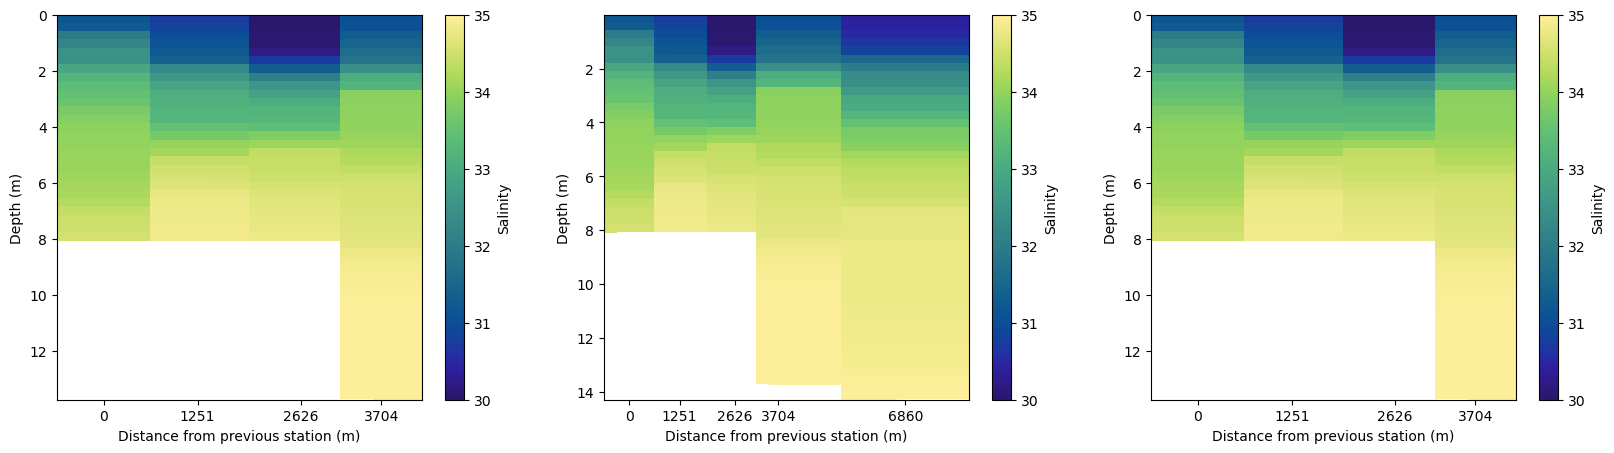

In [127]:
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
PC = axs[0].pcolor(D, depths, salinity, vmin = 30, vmax = 35, cmap = cm.cm.haline);
cbar = plt.colorbar(PC)
cbar.set_label('Salinity');
axs[0].set_xticks(D[:, 0]);

PC = axs[1].pcolor(D2, depths2, salinity2, vmin = 30, vmax = 35, cmap = cm.cm.haline);
cbar = plt.colorbar(PC)
cbar.set_label('Salinity');
axs[1].set_xticks(D2[:, 0]);

PC = axs[2].pcolor(D3, depths3, salinity3, vmin = 30, vmax = 35, cmap = cm.cm.haline);
cbar = plt.colorbar(PC)
cbar.set_label('Salinity');
axs[2].set_xticks(D3[:, 0]);

for ax in axs:
    ax.invert_yaxis();
    ax.set_ylabel('Depth (m)');
    ax.set_xlabel('Distance from previous station (m)');

# Plotting temperature

Try using the code above to plot temperature cross sections (or any other variable of your choice)